In [ ]:
# library import

import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64

import matplotlib.mlab as mlab


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
%matplotlib inline

In [118]:
#load training data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [100]:
# Look at the summary of numerical variables for train data set
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Trip_duration
We can observe clearly that trip_duration has some abnormally high values (see max value). 

Passenger_count
The passenger_count variable has a minimum value of 0 passengers, which is not relevant in the context of this usecase. These observations are most likely errors and will need to removed from the dataset.

Longitude & latitude

Based on different coordinate estimates of New York City, the latitude and longitude ranges are as follows:
Latitude is between 40.7128 and 40.748817
Longitude is between - 74.0059 and - 73.968285
The statisical summary of pick-up and drop-off coordinates show max and min observations that fall outside of the NYC city coordinate range. I will exclude these data points as this analysis is limited to New York City


In [119]:
# Remove passenger_count outliers
train = train[train['passenger_count']>0]

# Remove coordinate outliers
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

# Remove trip_duration outliers
trip_duration_mean = np.mean(train['trip_duration'])
trip_duration_std = np.std(train['trip_duration'])
train = train[train['trip_duration']<=trip_duration_mean + 2*trip_duration_std]
train = train[train['trip_duration']>= trip_duration_mean - 2*trip_duration_std]



In [102]:
# Number of variables with missing values
variables_missing_value = train.isnull().sum()
variables_missing_value 

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values in the training data

Feature Generation

Here we make a very simple data pre-processing and feature selection.

In [120]:
#Convert timestamps to date object
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

#Extract date & time info into separate features from 'pickup_datetime'
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_time'] = train['pickup_datetime'].dt.time

# Other Datetime features
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_month'] = train['pickup_datetime'].dt.month # Extract month

# Drop concatentated timestamp columns
train.drop(['pickup_datetime'], axis = 1, inplace = True)
train.drop(['dropoff_datetime'], axis = 1, inplace = True)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



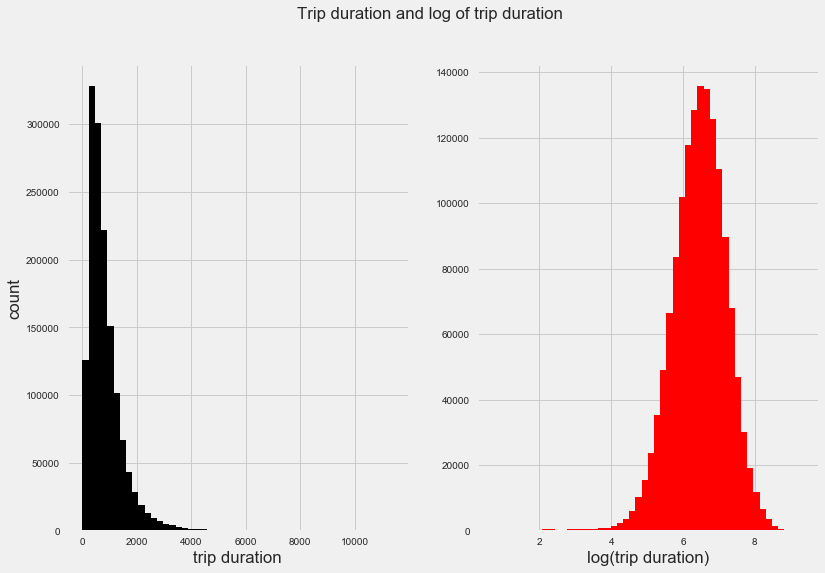

In [65]:
# Plot of trip duration & log(trip_duration)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(train.trip_duration,color='black',bins=50)
ax2.hist(np.log(train['trip_duration'].values+1),bins=50,color='red');

We can clearly observe that trip_duration is highly skewed to the right (left graph). 
So I applied log transformation to trip_duration which will normalize its distribution (right graph) and 
reduce the influence of these high observations in the right tail.

Passenger Count

Ideally, trips with more passengers should take longer. 

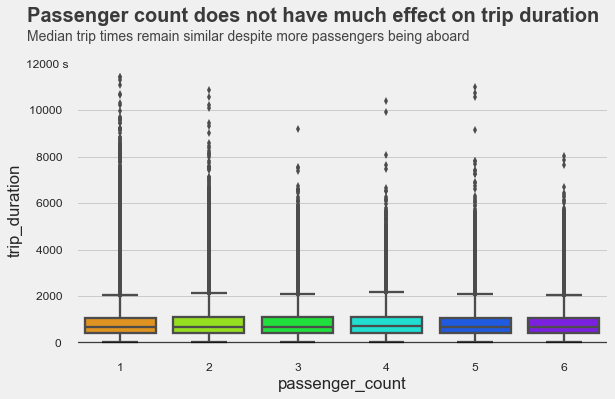

passenger_count,1,2,3,4,5,6
count,1.018715e+06,206864.000000,58989.000000,27957.000000,76912.000000,47639.000000
mean,8.126992e+02,863.614616,854.393989,874.580427,832.905814,825.457125
std,6.340959e+02,682.049230,657.984730,689.185733,647.936158,643.767072
min,1.000000e+00,1.000000,2.000000,2.000000,2.000000,2.000000
25%,3.880000e+02,412.000000,415.000000,419.000000,397.000000,395.000000
50%,6.470000e+02,681.000000,679.000000,690.000000,661.000000,655.000000
75%,1.043000e+03,1099.000000,1091.000000,1115.000000,1067.000000,1058.000000
max,1.141100e+04,10864.000000,9197.000000,10380.000000,10981.000000,8041.000000


In [113]:
# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
passenger_graph = sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
passenger_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
passenger_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
passenger_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add an extra vertical line by tweaking the range of the x-axis

# Remove the label of the x-axis
#passenger_graph.xaxis.label.set_visible(False)
#passenger_graph.yaxis.label.set_visible(False)

# # Adding a title and a subtitle
passenger_graph.text(x =-1.05, y = 13800, s = "Passenger count does not have much effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
passenger_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times remain similar despite more passengers being aboard',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train.groupby('passenger_count')['trip_duration'].describe().transpose()

However, we don't observe it in the data. The median trip_duration does not vary much as passenger_count increases.

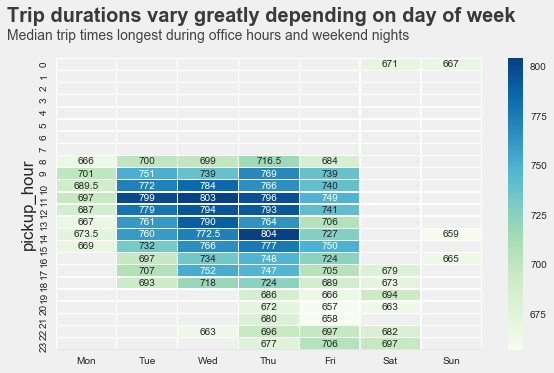

In [105]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(8.5,5))
pickup_hourday = train.groupby(['pickup_hour','pickup_weekday'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)


# # Adding a title and a subtitle
hourday_graph.text(x =-.8, y = 27, s = "Trip durations vary greatly depending on day of week",
               fontsize =20 , weight = 'bold', alpha = .90)
hourday_graph.text(x =-.8, y = 25.5, 
               s = 'Median trip times longest during office hours and weekend nights',
              fontsize = 14, alpha = .85)


plt.show()

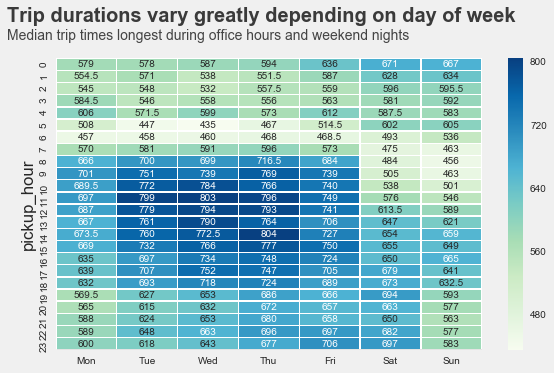

In [106]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(8.5,5))
pickup_hourday = train.groupby(['pickup_hour','pickup_weekday'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday,
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)


# # Adding a title and a subtitle
hourday_graph.text(x =-.8, y = 27, s = "Trip durations vary greatly depending on day of week",
               fontsize =20 , weight = 'bold', alpha = .90)
hourday_graph.text(x =-.8, y = 25.5, 
               s = 'Median trip times longest during office hours and weekend nights',
              fontsize = 14, alpha = .85)


plt.show()

Trip Duration by Pickup Hour and Day

We can clearly observe from above heatmap the peak hours:
    
Monday - Friday : 8:00am - 6:00pm which is the ususal office hours
Thursday, Friday, Saturday Nights: 6:00 pm - midnight
Early Saturday & Sunday Mornings: 12:00 am - 1:00 am
Sunday Afternoons: 2:00 pm and 4:00 pm

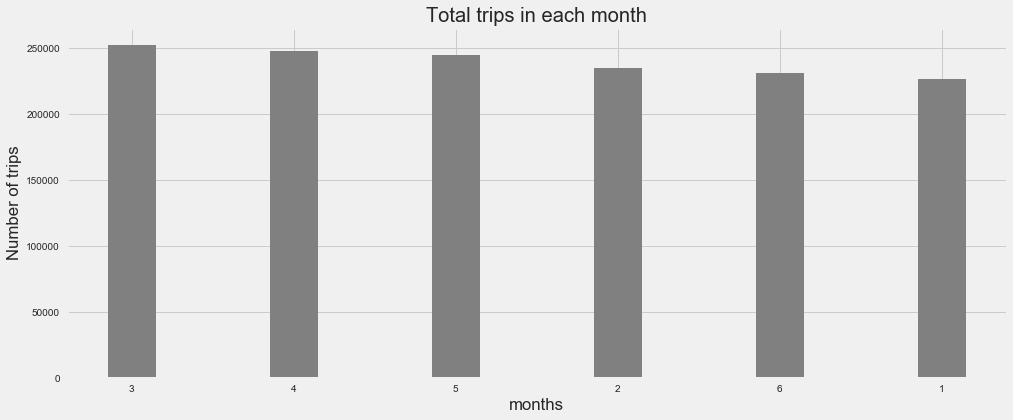

In [107]:
#Plotting trip count in each month
plt.figure(figsize=(15, 6)) 
train.pickup_month.value_counts().plot(kind='bar',color=["grey"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");

In [ ]:
Dont observe much variation in trip counts over the 6 months

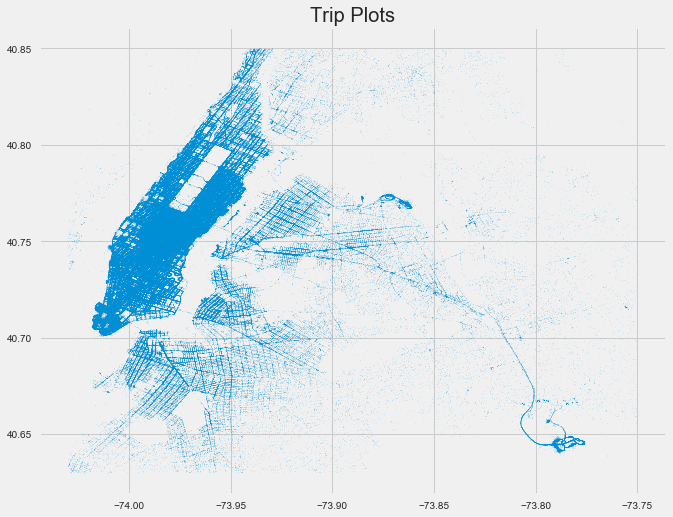

In [108]:
#lets plot the pick up and drop off points of each taxi ride

longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
plt.title('Trip Plots')
plt.show()

In [109]:
# Clustering

coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

#sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=62, batch_size=10000).fit(coords)

train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])


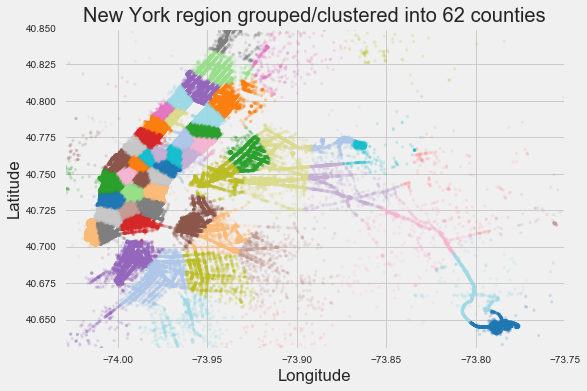

In [110]:
#Plotting clusters 
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values, train.pickup_latitude.values, s=10, lw=0,
           c=train.pickup_cluster.values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title("New York region grouped/clustered into 62 counties");
plt.show()

In [121]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')

# Distance
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)


train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2


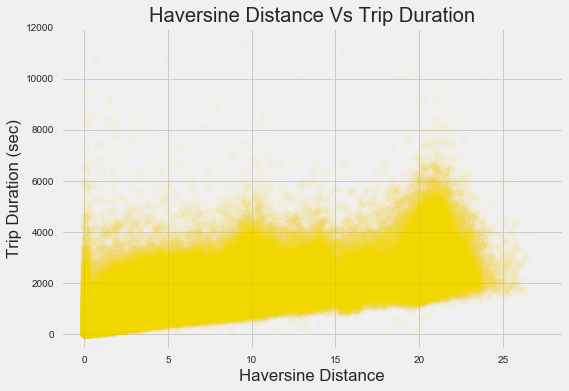

In [74]:
plt.scatter(train.distance_haversine,train.trip_duration,color="gold",alpha=0.04)
plt.ylabel("Trip Duration (sec)")
plt.xlabel("Haversine Distance")
plt.title("Haversine Distance Vs Trip Duration");

List the numerical features in decending order by their correlation with trip_duration:

distance_haversine: 0.7694468918426601
center_longitude: 0.39413303777733905
pickup_longitude: 0.3632691702226197
dropoff_longitude: 0.25548835909396256
center_latitude: -0.25391903369164986
pickup_latitude: -0.23548982525753842
dropoff_latitude: -0.19720945010930235
pickup_month: 0.059455091448905886
pickup_weekday: -0.03544469782338135
pickup_hour: 0.03025386122067256
passenger_count: 0.015344197884831583


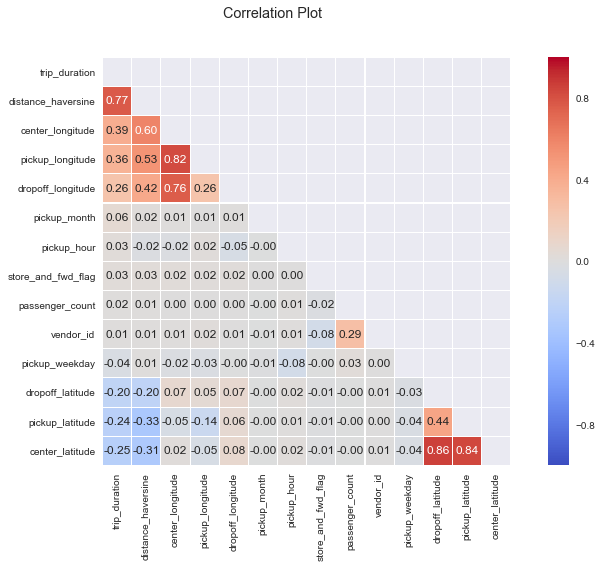

In [122]:
# Correlations to trip_duration
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['trip_duration'].to_dict()
del cor_dict['trip_duration']
print("List the numerical features in decending order by their correlation with trip_duration:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))
    
# Correlation matrix heatmap
corrmat = train.corr()
plt.figure(figsize=(12, 7))

# Number of variables for heatmap
k = 76
cols = corrmat.nlargest(k, 'trip_duration')['trip_duration'].index
cm = np.corrcoef(train[cols].values.T)

# Generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
sns.plt.suptitle('Correlation Plot')
plt.show() 

distance_haversine has a strong +ve correlation (0.77) with trip_duration. Other than that there doesn't appear to be much of a linear relationship between our target variable and the remaining features.

In [76]:
# Remove unnecessary features
train.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_date','pickup_time' ], 
                axis = 1, inplace = True)

In [77]:
train.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'pickup_weekday', 'pickup_hour', 'pickup_month', 'pickup_cluster',
       'dropoff_cluster', 'distance_haversine', 'center_latitude',
       'center_longitude'],
      dtype='object')

In [78]:
#Compute dependent variable and separate it from the data which has independent factors
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
train_df=train
target=train['log_trip_duration']
train_df.drop(['trip_duration','log_trip_duration'], 
                axis = 1, inplace = True)

#train_variables_sample = train_df[:500000]
#target_sample = target[:500000]

In [79]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
# Import error function
from sklearn.metrics import mean_squared_error
from math import sqrt

# Compute performance metric
def performance_metric(y_true, y_predict):
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = sqrt(mean_squared_error(y_true, y_predict))
    
    # Return the score
    return score

In [80]:



#Develop benchmark Model

from sklearn import linear_model
from sklearn.metrics import r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error


print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

print("RMSE: %.2f"
      % performance_metric(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [  5.44429736e-03   5.63178600e-03  -2.58272840e-04  -1.41958088e-02
   5.52158712e-03   1.68004261e-02  -1.58751469e-04   2.89014154e-04
   1.71284700e-01   1.95726120e+00  -7.15056769e+00]
Mean squared error: 0.32
RMSE: 0.56
Variance score: 0.46


In [81]:
#Create randomforest regressor object with different parameter values
from sklearn.ensemble import RandomForestRegressor
rf_model0 = RandomForestRegressor(random_state=50, verbose=1)
rf_model1 = RandomForestRegressor(n_estimators=50, max_features = 'auto', min_samples_leaf=50, min_samples_split=75, random_state=50, verbose=1)
rf_model2 = RandomForestRegressor(n_estimators=100, max_features = 'auto', min_samples_leaf=50, min_samples_split=75,random_state=50, verbose=1)
rf_model3 = RandomForestRegressor(n_estimators=150, max_features = 'auto', min_samples_leaf=50, min_samples_split=75,random_state=50, verbose=1)
rf_model4 = RandomForestRegressor(n_estimators=50, max_features = 'sqrt', min_samples_leaf=50, min_samples_split=75,random_state=50, verbose=1)
rf_model5 = RandomForestRegressor(n_estimators=100, max_features = 'sqrt', min_samples_leaf=50, min_samples_split=75,random_state=50, verbose=1)
rf_model6 = RandomForestRegressor(n_estimators=150, max_features = 'sqrt', min_samples_leaf=50, min_samples_split=75,random_state=50, verbose=1)
rf_model7 = RandomForestRegressor(n_estimators=10, max_features = 'auto', min_samples_leaf=50, min_samples_split=75,random_state=50, verbose=1)
rf_model8 = RandomForestRegressor(n_estimators=10, max_features = 'sqrt', min_samples_leaf=50, min_samples_split=75,random_state=50, verbose=1)


In [82]:
#Fit regressor on training data and compute the performance metric for each iteration
rf_model0.fit(X_train, y_train)
model0_predictions = rf_model0.predict(X_test)

rf_model1.fit(X_train, y_train)
model1_predictions = rf_model1.predict(X_test)

rf_model2.fit(X_train, y_train)
model2_predictions = rf_model2.predict(X_test)

rf_model3.fit(X_train, y_train)
model3_predictions = rf_model3.predict(X_test)

rf_model4.fit(X_train, y_train)
model4_predictions = rf_model4.predict(X_test)

rf_model5.fit(X_train, y_train)
model5_predictions = rf_model5.predict(X_test)

rf_model6.fit(X_train, y_train)
model6_predictions = rf_model6.predict(X_test)

rf_model7.fit(X_train, y_train)
model7_predictions = rf_model7.predict(X_test)

rf_model8.fit(X_train, y_train)
model8_predictions = rf_model8.predict(X_test)


print ("Accuracy score on testing data(model0): {:.4f}".format(performance_metric(y_test, model0_predictions)))
print ("Accuracy score on testing data(model1): {:.4f}".format(performance_metric(y_test, model1_predictions)))
print ("Accuracy score on testing data(model2): {:.4f}".format(performance_metric(y_test, model2_predictions)))
print ("Accuracy score on testing data(model3): {:.4f}".format(performance_metric(y_test, model3_predictions)))
print ("Accuracy score on testing data(model4): {:.4f}".format(performance_metric(y_test, model4_predictions)))
print ("Accuracy score on testing data(model5): {:.4f}".format(performance_metric(y_test, model5_predictions)))
print ("Accuracy score on testing data(model6): {:.4f}".format(performance_metric(y_test, model6_predictions)))
print ("Accuracy score on testing data(model7): {:.4f}".format(performance_metric(y_test, model7_predictions)))
print ("Accuracy score on testing data(model8): {:.4f}".format(performance_metric(y_test, model8_predictions)))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  7.0min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.7min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 18.9min finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.8min finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]

Accuracy score on testing data(model0): 0.3863
Accuracy score on testing data(model1): 0.3773
Accuracy score on testing data(model2): 0.3771
Accuracy score on testing data(model3): 0.3770
Accuracy score on testing data(model4): 0.3838
Accuracy score on testing data(model5): 0.3838
Accuracy score on testing data(model6): 0.3836
Accuracy score on testing data(model7): 0.3788
Accuracy score on testing data(model8): 0.3864


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [87]:
#Do 3 fold cross validation on the final model & compute performance metric
from sklearn.cross_validation import cross_val_score


def validation_metric(randomforest, y_true, y_predict):
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = sqrt(mean_squared_error(y_true, y_predict))
    
    # Return the score
    return score

clf = RandomForestRegressor(random_state=50, verbose=1)
 #Initialize with whatever parameters you want to

# 3-Fold Cross validation
print (np.mean(cross_val_score(clf, train_df, target, cv=2)))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


0.738271871873


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.8s finished


In [93]:
from sklearn.metrics import make_scorer
scoring_fnc = make_scorer(performance_metric)

#clf1 = RandomForestRegressor(random_state=50, verbose=1)

print (np.mean(cross_val_score(rf_model3, train_df,  target, scoring = scoring_fnc, cv=3)))

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 16.6min finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 16.2min finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 15.9min finished


0.379408198188


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   14.5s finished


In [94]:
rf_model3.feature_importances_

array([  7.37299557e-03,   7.83327687e-04,   0.00000000e+00,
         2.15407368e-02,   5.75566577e-02,   4.10227328e-03,
         6.28524275e-03,   8.75683277e-03,   8.22807470e-01,
         4.16732732e-02,   2.91211898e-02])

Feature ranking:
1. feature 8 (0.822807)
2. feature 4 (0.057557)
3. feature 9 (0.041673)
4. feature 10 (0.029121)
5. feature 3 (0.021541)
6. feature 7 (0.008757)
7. feature 0 (0.007373)
8. feature 6 (0.006285)
9. feature 5 (0.004102)
10. feature 1 (0.000783)
11. feature 2 (0.000000)


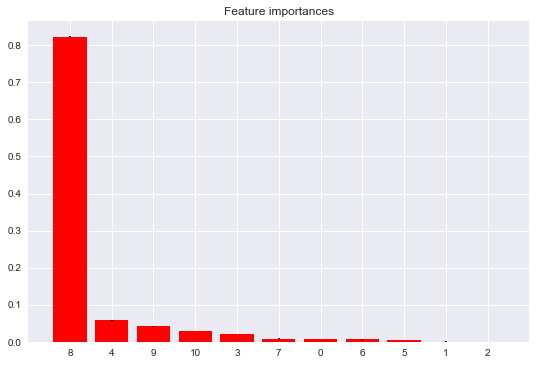

In [95]:
#Plot feaure importance
importances = rf_model3.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model3.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_df.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_df.shape[1]), indices)
plt.xlim([-1, train_df.shape[1]])
plt.show()